In [1]:
# the usual setup
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import timeit

# Simulation of individual nuclei
In the simplest case, we keep track of each nucleus and simulate it for each step separately. This implementation is not optimized for speed - we will look at this further down.

In [2]:
def sim_individual(N0,p,steps):

    # create an array for the state of each nucleus at each step
    nuclei = np.zeros((N0,steps),dtype=bool)
    nuclei[:,0] = True

    for n in range(N0):
        for i in range(1,steps):

            if nuclei[n,i-1] and np.random.uniform() > p:
                nuclei[n,i] = True

    return nuclei

We can print the history of all nuclei that are simulated in this way.

In [3]:
print(sim_individual(10,0.1,20).transpose())

[[ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [False  True  True  True  True  True  True  True  True  True]
 [False  True  True False  True  True False  True  True False]
 [False  True  True False  True  True False  True  True False]
 [False  True  True False  True  True False  True  True False]
 [False  True  True False  True  True False  True False False]
 [False  True  True False  True  True False  True False False]
 [False  True  True False  True  True False  True False False]
 [False  True  True False False  True False  True False False]
 [False  True  True False False  True False  True False False]
 [False  True  True False False  True False  True False False]
 [False  True  True False False False False  True False False]
 [False  True  True False False False False  True False False]
 [False  True  True False False False False  True False False]
 [False  True  True False False False False False False

We could also draw a visualisation of all the nuclei. Feel free to try this here:

Finally, we want to know how fast this runs:

In [4]:
navg = 5
N0 = 1000
ttot = timeit.timeit(stmt="sim_individual(N0,0.1,100)", setup="from __main__ import sim_individual,N0", number=navg)
print("Average simulation time per nucleus:", ttot/navg/N0, "seconds")

Average simulation time per nucleus: 4.2746451799999716e-05 seconds


# Simulation of a set of nuclei

If we are not interested in the fate of a single nucleus, then we can skip the big array that keeps the entire history and just simulate the remaining nuclei. This makes the code quite a bit faster.

In [5]:
def sim_direct(N0,p,steps):
    N = np.zeros(steps,dtype=int)
    N[0]=N0 # initial number of nuclei
    #     p = 0.1 # decay probability in one step

    for i in range(len(N)-1):
        # generate n random numbers
        r = np.random.uniform(low=0.0, high=1.0, size=(N[i],))

        # count the number of surviving nuclei (r>p) and store in the variable
        N[i+1] = np.count_nonzero(r>p)

    return N

Text(0, 0.5, 'N')

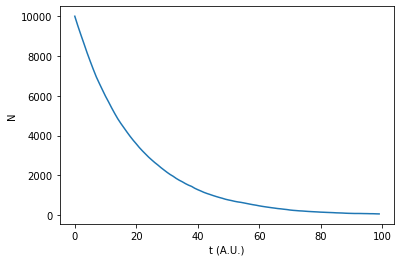

In [6]:
plt.plot(sim_direct(10000,0.05,100))
plt.xlabel("t (A.U.)")
plt.ylabel("N")

In [7]:
navg = 10
N0=100000
ttot = timeit.timeit(stmt="sim_direct(N0,0.05,100)", setup="from __main__ import sim_direct,N0", number=navg)
print("Average simulation time per nucleus:", ttot/navg/N0, "seconds")

Average simulation time per nucleus: 2.1268697300000028e-07 seconds


# Inverse Transform Sampling

In this way, we still need to generate a random number for each timestep and each nucleus. If we know the distribution how the life time of the nuclei is distributed (it's exponential), then we can sample it directly. For this simple case, we can use inverse transform sampling.

In [8]:
def sim_inverse_transform(N0,scale=1.0,tbins=None):

    # the actual simulation
    t = - np.log(np.random.uniform(size=N0)) / scale

    # this part is just bookkeeping / reporting
    if tbins is not None:
        return [np.count_nonzero(i<t) for i in tbins]
    else:
        return t

In [9]:
sim_inverse_transform(10)

array([2.28748151, 1.31234694, 0.5372189 , 0.29027868, 0.21566845,
       3.56190753, 2.98642941, 1.14817272, 0.75593052, 2.41659273])

Text(0, 0.5, 'N')

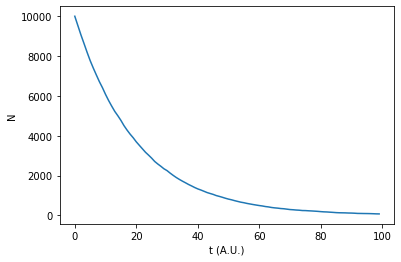

In [10]:
plt.plot(sim_inverse_transform(10000,1.0,np.linspace(0.,5.0,100)))
plt.xlabel("t (A.U.)")
plt.ylabel("N")

In [11]:
navg = 10
N0=1000000
ttot = timeit.timeit(stmt="sim_inverse_transform(N0)", setup="from __main__ import sim_inverse_transform,N0", number=navg)
print("Average simulation time per nucleus:", ttot/navg/N0, "seconds")

Average simulation time per nucleus: 2.1637653200000172e-08 seconds


In [12]:
t = sim_inverse_transform(10000)
np.count_nonzero(t>4)

161

In [13]:
n = np.zeros(1000)
for i,nn in enumerate(n):
    n[i] = np.count_nonzero(sim_inverse_transform(100)>4)
# print(n)

(array([146., 306., 273.,   0., 162.,  82.,   0.,  22.,   7.,   2.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

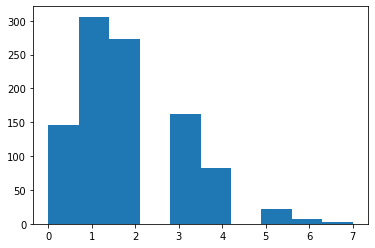

In [14]:
plt.hist(n)